In [84]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('src')

from utils import *
import time
from tqdm import tqdm_notebook
import os
from sklearn import svm as sksvm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from src import svm
from native_utils import coordinate_descent

# Spectrum experiments

In [106]:
import spectrum

In [149]:
for k in range(1, 102):
    precomputed_kernels(k_spectrum, 'spectrum_{}'.format(k), k=k)

In [203]:
for k in [50, 60, 70, 80, 90, 100, 101]:
    Ks = precomputed_kernels(k_spectrum, 'spectrum_{}'.format(k), k=k)
    res = svm_kernels(Ks, sksvm.SVC, kernel='precomputed')
    with open('spectrum_res_large.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

dataset: Validation 52.20 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 70.90 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 64.40 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 62.50 ± 0.00	 Train 100.00 ± 0.00	
dataset: Validation 52.25 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 70.35 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 63.35 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 61.98 ± 0.00	 Train 100.00 ± 0.00	
dataset: Validation 52.25 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 70.15 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 61.15 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 61.18 ± 0.00	 Train 100.00 ± 0.00	
dataset: Validation 52.25 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 69.55 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 60.00 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
total:   Validation 60.60 ± 0.00	 Train 100.00 ± 0.00	
dataset: Validation 52.0

In [82]:
def load_results(file):
    with open(file, 'r') as src:
        content = src.readlines()
    ks = []
    scores = []
    
    for line in content:
        line = list(map(float, line.strip().split()))
        assert(len(line) == 7)
        ks.append(int(line[0]))
        scores.append(line[1:])
    
    ks = np.array(ks)
    scores = np.array(scores)
    
    return ks, scores


def plot_validation(file, name=None):
    if name is None:
        name = file
    ks, scores = load_results(file)
    plt.plot(ks, np.mean(scores[:, [0, 2, 4]], axis=1), label=name)

    
def plot_results(show=True, **params):
    for name in params:
        plot_validation(params[name], name=name)
    
    plt.xlabel("Parameter k")
    plt.legend()
    if show:
        plt.show()

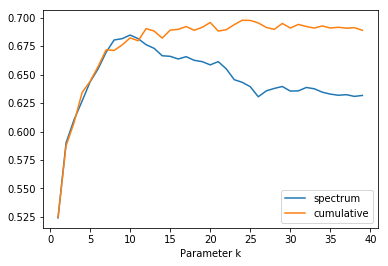

In [262]:
plot_results(spectrum='spectrum_res.txt', cumulative='cum_spectrum_res.txt')

## Cum-spectrum

In [ ]:
Ks = None
for k in range(1, 40):
    new_Ks = precomputed_kernels(k_spectrum, 'spectrum_{}'.format(k), k=k)
    if Ks is None:
        Ks = new_Ks
    else:
        Ks = transform_kernels([Ks, new_Ks], lambda i, K1, K2: K1 + K2)
    res = svm_kernels(transform_kernels([Ks], lambda i, K1: K1 / k), sksvm.SVC, kernel='precomputed')
    with open('cum_spectrum_res.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

## Weighted cum spectrum

In [80]:
def weighted_cum_spectrum(k, T=1):
    ks, weights = load_results('spectrum_res.txt')
    weights = weights[:k, [0, 2, 4]]
    weights = np.exp(T * weights)
    weights /= np.sum(weights, axis=0)[None, :]
    
    print(weights)
    
    Ks = None
    for i in range(1, k+1):
        new_Ks = precomputed_kernels(k_spectrum, 'spectrum_{}'.format(i), k=i)
        w = weights[i-1]
        
        if Ks is None:
            Ks = transform_kernels([new_Ks], lambda j, K: w[j] * K)
        else:
            Ks = transform_kernels([Ks, new_Ks], lambda j, K1, K2: K1 + w[j] * K2)
        
    return Ks

In [86]:
svm_kernels(weighted_cum_spectrum(39, T=50), svm.SVCCoordinate, kernel='precomputed', intercept=1, loss='hinge')

[[6.21022377e-04 3.26695202e-07 4.60071275e-05]
 [5.89209626e-03 3.59192137e-05 8.57307214e-04]
 [5.73178352e-02 1.13439806e-04 5.89218057e-04]
 [3.30695142e-02 8.81189195e-04 1.52354682e-03]
 [1.67940850e-01 1.60563140e-03 2.05657309e-03]
 [2.32435284e-01 7.19594069e-03 1.86086429e-03]
 [1.21341858e-01 6.17761318e-02 3.65479883e-03]
 [1.01861275e-01 7.35905833e-02 1.85605999e-02]
 [4.93339180e-02 1.67924937e-01 2.00061765e-02]
 [3.56451052e-02 1.21330360e-01 6.16233620e-02]
 [2.77604359e-02 8.13301725e-02 7.34085968e-02]
 [2.05654367e-02 4.81112999e-02 7.52669443e-02]
 [1.77008354e-02 3.14537142e-02 8.31828379e-02]
 [1.60163782e-02 1.81472144e-02 6.01018757e-02]
 [1.60163782e-02 2.21650578e-02 4.56517094e-02]
 [1.10078850e-02 2.05634880e-02 5.04529415e-02]
 [1.72638002e-02 1.86066133e-02 4.79923226e-02]
 [1.21655944e-02 1.81472144e-02 4.34252492e-02]
 [1.07360994e-02 1.72621643e-02 4.34252492e-02]
 [1.02124936e-02 1.37841182e-02 3.73764584e-02]
 [1.24735679e-02 2.00557736e-02 3.217021

[array([0.6345    , 0.        , 0.95097368, 0.        ]),
 array([0.7755, 0.    , 1.    , 0.    ]),
 array([0.704, 0.   , 1.   , 0.   ])]

In [394]:
svm_kernels(weighted_cum_spectrum(20, T=50), sksvm.SVC, kernel='precomputed')

[[6.43610469e-04 4.51220564e-07 6.85586186e-05]
 [6.10640611e-03 4.96104252e-05 1.27753680e-03]
 [5.94026241e-02 1.56679293e-04 8.78037343e-04]
 [3.42723327e-02 1.21706925e-03 2.27034964e-03]
 [1.74049267e-01 2.21764477e-03 3.06465146e-03]
 [2.40889519e-01 9.93879433e-03 2.77301131e-03]
 [1.25755356e-01 8.53231419e-02 5.44628566e-03]
 [1.05566217e-01 1.01640870e-01 2.76585208e-02]
 [5.11283124e-02 2.31932346e-01 2.98126812e-02]
 [3.69416042e-02 1.67577464e-01 9.18295229e-02]
 [2.87701503e-02 1.12330534e-01 1.09391572e-01]
 [2.13134516e-02 6.64497297e-02 1.12160833e-01]
 [1.83446578e-02 4.34428255e-02 1.23956890e-01]
 [1.65989328e-02 2.50643300e-02 8.95622439e-02]
 [1.65989328e-02 3.06136417e-02 6.80289838e-02]
 [1.14082685e-02 2.84016067e-02 7.51836544e-02]
 [1.78917265e-02 2.56988365e-02 7.15169043e-02]
 [1.26080866e-02 2.50643300e-02 6.47111711e-02]
 [1.11265974e-02 2.38419282e-02 6.47111711e-02]
 [1.05839468e-02 1.90381663e-02 5.56974211e-02]]
dataset: Validation 62.80 ± 0.00	 Train

[array([0.628, 0.   , 1.   , 0.   ]),
 array([0.775, 0.   , 1.   , 0.   ]),
 array([0.701 , 0.    , 0.9965, 0.    ])]

# Mismatch kernel

In [248]:
for k in range(1, 13):
    precomputed_kernels(k_spectrum_mismatch, 'mismatch_{}'.format(k), k=k)

In [249]:
for k in range(7, 13):
    Ks = precomputed_kernels(k_spectrum_mismatch, 'mismatch_{}'.format(k), k=k)
    res = svm_kernels(Ks, sksvm.SVC, kernel='precomputed')
    with open('mismatch_res.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

dataset: Validation 63.40 ± 0.00	 Train 88.36 ± 0.00	 C=1e+00
dataset: Validation 73.60 ± 0.00	 Train 92.56 ± 0.00	 C=1e+00
dataset: Validation 64.65 ± 0.00	 Train 88.97 ± 0.00	 C=1e+00
total:   Validation 67.22 ± 0.00	 Train 89.96 ± 0.00	
dataset: Validation 63.30 ± 0.00	 Train 95.28 ± 0.00	 C=1e+00
dataset: Validation 77.50 ± 0.00	 Train 98.03 ± 0.00	 C=1e+00
dataset: Validation 66.25 ± 0.00	 Train 95.76 ± 0.00	 C=1e+00
total:   Validation 69.02 ± 0.00	 Train 96.36 ± 0.00	
dataset: Validation 61.75 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 77.65 ± 0.00	 Train 99.80 ± 0.00	 C=1e+00
dataset: Validation 67.15 ± 0.00	 Train 98.42 ± 0.00	 C=1e+00
total:   Validation 68.85 ± 0.00	 Train 99.41 ± 0.00	
dataset: Validation 61.55 ± 0.00	 Train 98.21 ± 0.00	 C=1e+00
dataset: Validation 78.10 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 66.80 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 68.82 ± 0.00	 Train 99.40 ± 0.00	
dataset: Validation 61.80 ± 0.00	 Tra

## Cumulative

In [250]:
Ks = None
for k in range(1, 13):
    new_Ks = precomputed_kernels(k_spectrum_mismatch, 'mismatch_{}'.format(k), k=k)
    if Ks is None:
        Ks = new_Ks
    else:
        Ks = transform_kernels([Ks, new_Ks], lambda i, K1, K2: K1 + K2)
    res = svm_kernels(transform_kernels([Ks], lambda i, K1: K1 / k), sksvm.SVC, kernel='precomputed')
    with open('cum_mismatch_res.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

dataset: Validation 51.15 ± 0.00	 Train 51.15 ± 0.00	 C=1e-03
dataset: Validation 49.85 ± 0.00	 Train 52.20 ± 0.00	 C=1e+03
dataset: Validation 54.75 ± 0.00	 Train 55.49 ± 0.00	 C=1e+02
total:   Validation 51.92 ± 0.00	 Train 52.94 ± 0.00	
dataset: Validation 51.15 ± 0.00	 Train 51.15 ± 0.00	 C=1e-03
dataset: Validation 53.05 ± 0.00	 Train 54.33 ± 0.00	 C=1e+03
dataset: Validation 55.30 ± 0.00	 Train 55.63 ± 0.00	 C=1e+02
total:   Validation 53.17 ± 0.00	 Train 53.70 ± 0.00	
dataset: Validation 59.70 ± 0.00	 Train 63.17 ± 0.00	 C=1e+02
dataset: Validation 63.65 ± 0.00	 Train 66.99 ± 0.00	 C=1e+02
dataset: Validation 60.55 ± 0.00	 Train 61.68 ± 0.00	 C=1e+01
total:   Validation 61.30 ± 0.00	 Train 63.95 ± 0.00	
dataset: Validation 60.35 ± 0.00	 Train 69.66 ± 0.00	 C=1e+02
dataset: Validation 67.80 ± 0.00	 Train 74.84 ± 0.00	 C=1e+02
dataset: Validation 62.20 ± 0.00	 Train 70.88 ± 0.00	 C=1e+02
total:   Validation 63.45 ± 0.00	 Train 71.79 ± 0.00	
dataset: Validation 61.25 ± 0.00	 Train 

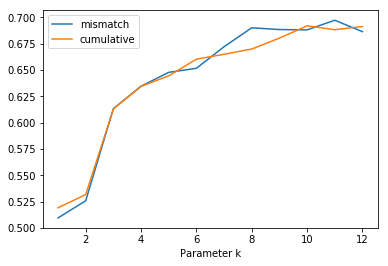

In [263]:
plot_results(mismatch='mismatch_res.txt', cumulative='cum_mismatch_res.txt')

# Mismatch, with decay = 1

In [252]:
for k in range(1, 13):
    precomputed_kernels(k_spectrum_mismatch, 'mismatch_1_{}'.format(k), k=k, decay=1)

In [256]:
for k in range(1, 13):
    Ks = precomputed_kernels(k_spectrum_mismatch, 'mismatch_1_{}'.format(k), k=k, decay=1)
    res = svm_kernels(Ks, sksvm.SVC, kernel='precomputed')
    with open('mismatch_1_res.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

dataset: Validation 51.15 ± 0.00	 Train 51.15 ± 0.00	 C=1e-03
dataset: Validation 45.40 ± 0.00	 Train 50.24 ± 0.00	 C=1e+03
dataset: Validation 45.45 ± 0.00	 Train 50.25 ± 0.00	 C=1e+01
total:   Validation 47.33 ± 0.00	 Train 50.55 ± 0.00	
dataset: Validation 55.70 ± 0.00	 Train 58.13 ± 0.00	 C=1e+03
dataset: Validation 60.30 ± 0.00	 Train 61.87 ± 0.00	 C=1e+03
dataset: Validation 60.85 ± 0.00	 Train 62.07 ± 0.00	 C=1e+02
total:   Validation 58.95 ± 0.00	 Train 60.69 ± 0.00	
dataset: Validation 59.55 ± 0.00	 Train 63.29 ± 0.00	 C=1e+01
dataset: Validation 63.25 ± 0.00	 Train 66.39 ± 0.00	 C=1e+02
dataset: Validation 61.30 ± 0.00	 Train 64.03 ± 0.00	 C=1e+02
total:   Validation 61.37 ± 0.00	 Train 64.57 ± 0.00	
dataset: Validation 59.10 ± 0.00	 Train 69.74 ± 0.00	 C=1e+02
dataset: Validation 66.05 ± 0.00	 Train 75.73 ± 0.00	 C=1e+03
dataset: Validation 62.05 ± 0.00	 Train 68.96 ± 0.00	 C=1e+01
total:   Validation 62.40 ± 0.00	 Train 71.48 ± 0.00	
dataset: Validation 60.20 ± 0.00	 Train 

In [254]:
Ks = None
for k in range(1, 13):
    new_Ks = precomputed_kernels(k_spectrum_mismatch, 'mismatch_1_{}'.format(k), k=k, decay=1)
    if Ks is None:
        Ks = new_Ks
    else:
        Ks = transform_kernels([Ks, new_Ks], lambda i, K1, K2: K1 + K2)
    res = svm_kernels(transform_kernels([Ks], lambda i, K1: K1 / k), sksvm.SVC, kernel='precomputed')
    with open('cum_mismatch_1_res.txt', 'a') as dst:
        dst.write('{} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}\n'.format(k, res[0][0], res[0][2], res[1][0], res[1][2], res[2][0], res[2][2]))

dataset: Validation 51.15 ± 0.00	 Train 51.15 ± 0.00	 C=1e-03
dataset: Validation 46.20 ± 0.00	 Train 50.23 ± 0.00	 C=1e+00
dataset: Validation 46.55 ± 0.00	 Train 50.19 ± 0.00	 C=1e+03
total:   Validation 47.97 ± 0.00	 Train 50.52 ± 0.00	
dataset: Validation 56.45 ± 0.00	 Train 57.84 ± 0.00	 C=1e+02
dataset: Validation 59.80 ± 0.00	 Train 61.81 ± 0.00	 C=1e+03
dataset: Validation 60.90 ± 0.00	 Train 61.84 ± 0.00	 C=1e+02
total:   Validation 59.05 ± 0.00	 Train 60.50 ± 0.00	
dataset: Validation 59.10 ± 0.00	 Train 64.17 ± 0.00	 C=1e+03
dataset: Validation 62.40 ± 0.00	 Train 66.92 ± 0.00	 C=1e+03
dataset: Validation 59.95 ± 0.00	 Train 64.70 ± 0.00	 C=1e+03
total:   Validation 60.48 ± 0.00	 Train 65.26 ± 0.00	
dataset: Validation 59.80 ± 0.00	 Train 66.26 ± 0.00	 C=1e+01
dataset: Validation 69.05 ± 0.00	 Train 76.71 ± 0.00	 C=1e+03
dataset: Validation 61.55 ± 0.00	 Train 66.32 ± 0.00	 C=1e+01
total:   Validation 63.47 ± 0.00	 Train 69.76 ± 0.00	
dataset: Validation 60.90 ± 0.00	 Train 

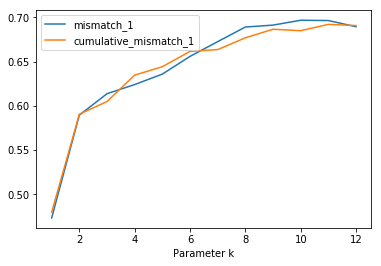

In [264]:
plot_results(mismatch_1='mismatch_1_res.txt', cumulative_mismatch_1='cum_mismatch_1_res.txt')

## Weighted cum mismatch

In [285]:
def weighted_cum_mismatch(T=1, use_1=True):
    ks, weights = load_results('mismatch{}_res.txt'.format('_1' * use_1))
    weights = weights[:, [0, 2, 4]]
    weights = np.exp(T * weights)
    weights /= np.sum(weights, axis=0)[None, :]
    
    print(weights)
    
    Ks = None
    for i in range(1, 1+len(weights)):
        new_Ks = precomputed_kernels(k_spectrum_mismatch, 'mismatch{}_{}'.format('_1'*use_1, i), k=i)
        w = weights[i-1]
        
        if Ks is None:
            Ks = transform_kernels([new_Ks], lambda j, K: w[j] * K)
        else:
            Ks = transform_kernels([Ks, new_Ks], lambda j, K1, K2: K1 + w[j] * K2)
        
    return Ks

In [302]:
svm_kernels(weighted_cum_mismatch(T=100, use_1=True), sksvm.SVC, kernel='precomputed')

[[1.42823936e-06 1.03020922e-15 9.52181231e-12]
 [1.35157730e-04 3.04728598e-09 4.64359824e-05]
 [6.35147577e-03 5.82213048e-08 7.28261170e-05]
 [4.04987975e-03 9.57428793e-07 1.54172891e-04]
 [1.21665112e-02 8.21939061e-06 2.08111635e-04]
 [7.36031034e-02 2.72188835e-04 4.19085368e-04]
 [2.00073978e-01 6.04203450e-03 1.03078367e-03]
 [4.92102580e-01 5.45294429e-02 6.55559814e-03]
 [8.55146059e-02 1.72214500e-01 2.28812858e-02]
 [4.69314108e-02 5.71772276e-01 6.53867319e-02]
 [7.36031034e-02 1.48226394e-01 1.45520848e-01]
 [5.46676585e-03 4.69339265e-02 7.57724120e-01]]
dataset: Validation 63.85 ± 0.00	 Train 95.44 ± 0.00	 C=1e+00
dataset: Validation 79.35 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 70.00 ± 0.00	 Train 99.42 ± 0.00	 C=1e+00
total:   Validation 71.07 ± 0.00	 Train 98.29 ± 0.00	


[array([0.6385    , 0.        , 0.95439474, 0.        ]),
 array([0.7935, 0.    , 1.    , 0.    ]),
 array([0.7       , 0.        , 0.99423684, 0.        ])]

In [307]:
svm_kernels(weighted_cum_mismatch(T=100, use_1=True), svm.SVCCoordinate, kernel='precomputed', intercept=1, loss='hinge')

[[1.42823936e-06 1.03020922e-15 9.52181231e-12]
 [1.35157730e-04 3.04728598e-09 4.64359824e-05]
 [6.35147577e-03 5.82213048e-08 7.28261170e-05]
 [4.04987975e-03 9.57428793e-07 1.54172891e-04]
 [1.21665112e-02 8.21939061e-06 2.08111635e-04]
 [7.36031034e-02 2.72188835e-04 4.19085368e-04]
 [2.00073978e-01 6.04203450e-03 1.03078367e-03]
 [4.92102580e-01 5.45294429e-02 6.55559814e-03]
 [8.55146059e-02 1.72214500e-01 2.28812858e-02]
 [4.69314108e-02 5.71772276e-01 6.53867319e-02]
 [7.36031034e-02 1.48226394e-01 1.45520848e-01]
 [5.46676585e-03 4.69339265e-02 7.57724120e-01]]
dataset: Validation 63.55 ± 0.00	 Train 95.47 ± 0.00	 C=1e+00
dataset: Validation 79.30 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 70.20 ± 0.00	 Train 99.42 ± 0.00	 C=1e+00
total:   Validation 71.02 ± 0.00	 Train 98.30 ± 0.00	


[array([0.6355    , 0.        , 0.95473684, 0.        ]),
 array([0.793, 0.   , 1.   , 0.   ]),
 array([0.702     , 0.        , 0.99423684, 0.        ])]

In [303]:
svm_kernels(weighted_cum_mismatch(T=100, use_1=False), sksvm.SVC, kernel='precomputed')

[[1.73954632e-06 1.23435768e-14 1.25649989e-07]
 [1.73954632e-06 2.47287279e-12 8.42257067e-08]
 [9.93306474e-03 1.33971256e-07 6.84254547e-05]
 [4.23457925e-02 8.93405153e-06 1.44856689e-04]
 [1.90271911e-02 2.96620957e-05 5.04294190e-03]
 [2.10282982e-02 4.63993244e-04 9.21262398e-04]
 [3.63532632e-01 3.60425363e-03 3.21552172e-03]
 [3.28937928e-01 1.78058957e-01 1.59265833e-02]
 [6.98164088e-02 2.06874993e-01 3.91730740e-02]
 [5.71608410e-02 3.24444572e-01 2.76047987e-02]
 [7.33959726e-02 2.40354451e-01 4.53951163e-01]
 [1.48183913e-02 4.61600503e-02 4.53951163e-01]]
dataset: Validation 63.50 ± 0.00	 Train 94.30 ± 0.00	 C=1e+00
dataset: Validation 78.65 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 68.75 ± 0.00	 Train 99.29 ± 0.00	 C=1e+00
total:   Validation 70.30 ± 0.00	 Train 97.87 ± 0.00	


[array([0.635     , 0.        , 0.94302632, 0.        ]),
 array([0.7865, 0.    , 1.    , 0.    ]),
 array([0.6875    , 0.        , 0.99294737, 0.        ])]

# Summary

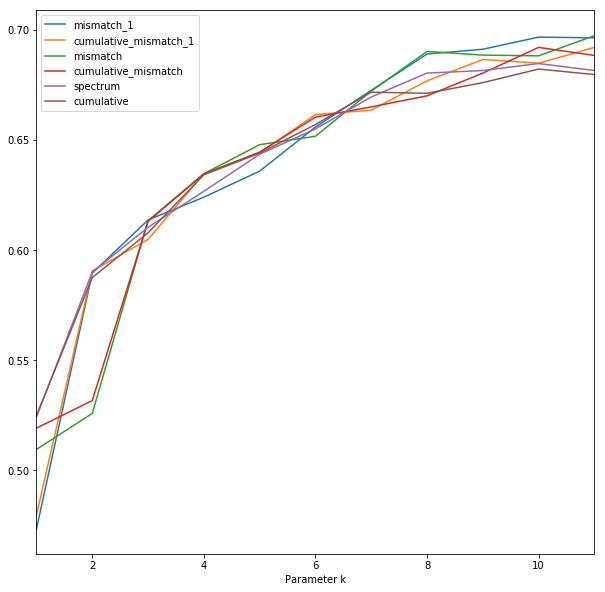

In [304]:
plt.figure(figsize=(10, 10))
plot_results(
    mismatch_1='mismatch_1_res.txt',
    cumulative_mismatch_1='cum_mismatch_1_res.txt',
    mismatch='mismatch_res.txt',
    cumulative_mismatch='cum_mismatch_res.txt',
    spectrum='spectrum_res.txt',
    cumulative='cum_spectrum_res.txt',
    show=False)
plt.xlim(1, 11)
plt.show()

# Edit kernel

In [361]:
def edit_distance():
    with open('kernels/levenshtein_distance', 'rb') as src:
        return transform_kernels([pickle.load(src)], lambda i, K: K.data)


def edit_kernel(kernel='gaussian', scale=1, d=1):
    edit_distances = edit_distance()
    if kernel == 'gaussian':
        return transform_kernels([edit_distances], lambda i, K: np.exp(-(K/scale) ** 2))
    elif kernel == 'exp':
        return transform_kernels([edit_distances], lambda i, K: np.exp(-K/scale))
    elif kernel == 'polynomial':
        return transform_kernels([edit_distances], lambda i, K: 1 / (1 + (K/scale) ** d))
    else:
        raise ValueError("Unknown kernel.")

## Exponential

In [384]:
np.mean(edit_kernel(kernel='exp', scale=1)[0][2])

0.0009772573

In [347]:
%time _ = svm_kernels(edit_kernel(kernel='exp', scale=1), sksvm.SVC, kernel='precomputed')

dataset: Validation 56.90 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 69.90 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 64.25 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 63.68 ± 0.00	 Train 100.00 ± 0.00	
Wall time: 15.1 s


[array([0.569, 0.   , 1.   , 0.   ]),
 array([0.699, 0.   , 1.   , 0.   ]),
 array([0.6425, 0.    , 1.    , 0.    ])]

## Gaussian

In [357]:
for scale in np.linspace(2.5, 3.5, 5):
    print("Scale", scale)
    svm_kernels(edit_kernel(kernel='gaussian', scale=scale), sksvm.SVC, kernel='precomputed')

Scale 2.5
dataset: Validation 57.50 ± 0.00	 Train 97.23 ± 0.00	 C=1e+00
dataset: Validation 69.75 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 64.75 ± 0.00	 Train 99.26 ± 0.00	 C=1e+00
total:   Validation 64.00 ± 0.00	 Train 98.83 ± 0.00	
Scale 2.75
dataset: Validation 57.80 ± 0.00	 Train 96.92 ± 0.00	 C=1e+00
dataset: Validation 69.85 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 64.25 ± 0.00	 Train 99.11 ± 0.00	 C=1e+00
total:   Validation 63.97 ± 0.00	 Train 98.68 ± 0.00	
Scale 3.0
dataset: Validation 58.00 ± 0.00	 Train 96.61 ± 0.00	 C=1e+00
dataset: Validation 69.60 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 63.35 ± 0.00	 Train 99.05 ± 0.00	 C=1e+00
total:   Validation 63.65 ± 0.00	 Train 98.55 ± 0.00	
Scale 3.25
dataset: Validation 58.25 ± 0.00	 Train 96.29 ± 0.00	 C=1e+00
dataset: Validation 70.35 ± 0.00	 Train 99.99 ± 0.00	 C=1e+00
dataset: Validation 64.00 ± 0.00	 Train 98.98 ± 0.00	 C=1e+00
total:   Validation 64.20 ± 0.00	 Train 98.42 ± 0

In [362]:
_ = svm_kernels(edit_kernel(kernel='gaussian', scale=3.25), sksvm.SVC, kernel='precomputed')

dataset: Validation 57.80 ± 0.00	 Train 96.26 ± 0.00	 C=1e+00
dataset: Validation 70.60 ± 0.00	 Train 99.99 ± 0.00	 C=1e+00
dataset: Validation 63.95 ± 0.00	 Train 98.98 ± 0.00	 C=1e+00
total:   Validation 64.12 ± 0.00	 Train 98.41 ± 0.00	


## Polynomial

In [371]:
_ = svm_kernels(edit_kernel(kernel='polynomial', scale=0.1, d=1), sksvm.SVC, kernel='precomputed')

dataset: Validation 55.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 69.85 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 61.40 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
total:   Validation 62.40 ± 0.00	 Train 100.00 ± 0.00	


In [375]:
for d in np.linspace(0.5, 1., 5):
    print("d", d)
    svm_kernels(edit_kernel(kernel='polynomial', scale=0.1, d=d), sksvm.SVC, kernel='precomputed')

d 0.5
dataset: Validation 55.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 68.70 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 59.30 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 61.32 ± 0.00	 Train 100.00 ± 0.00	
d 0.625
dataset: Validation 55.85 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 69.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 60.45 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 62.08 ± 0.00	 Train 100.00 ± 0.00	
d 0.75
dataset: Validation 56.20 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 69.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 60.40 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 62.18 ± 0.00	 Train 100.00 ± 0.00	
d 0.875
dataset: Validation 55.90 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 70.05 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 61.40 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
total:   Validation 62.45 ± 0.00	 Train 100.00 ± 0

In [378]:
for scale in np.linspace(0.01, 1, 10):
    print("scale", scale)
    svm_kernels(edit_kernel(kernel='polynomial', scale=scale, d=0.8), sksvm.SVC, kernel='precomputed')

scale 0.01
dataset: Validation 53.10 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 68.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 60.20 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 60.75 ± 0.00	 Train 100.00 ± 0.00	
scale 0.12
dataset: Validation 55.70 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 70.10 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 60.90 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 62.23 ± 0.00	 Train 100.00 ± 0.00	
scale 0.23
dataset: Validation 56.00 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 70.00 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 60.30 ± 0.00	 Train 99.96 ± 0.00	 C=1e+00
total:   Validation 62.10 ± 0.00	 Train 99.99 ± 0.00	
scale 0.34
dataset: Validation 55.50 ± 0.00	 Train 99.66 ± 0.00	 C=1e+00
dataset: Validation 68.70 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 60.80 ± 0.00	 Train 99.80 ± 0.00	 C=1e+00
total:   Validation 61.67 ± 0.00	 Train

In [420]:
%time _ = svm_kernels(edit_kernel(kernel='polynomial', scale=0.5, d=0.8), sksvm.SVC, kernel='precomputed')

dataset: Validation 56.25 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 68.95 ± 0.00	 Train 100.00 ± 0.00	 C=1e+00
dataset: Validation 60.45 ± 0.00	 Train 99.50 ± 0.00	 C=1e+00
total:   Validation 61.88 ± 0.00	 Train 99.83 ± 0.00	
Wall time: 16.1 s


**Best edit kernel: Gaussian; Scale 3.25**

# FINAL SUBMISSION

## Evaluating single kernels

### List of single kernels

In [442]:
kernels = dict()

**Spectrum kernels**

In [443]:
for k in range(1, 40):
    name = 'spectrum_{}'.format(k)
    kernels[name] = (precomputed_kernels, dict(kernel=k_spectrum, name=name, k=k))

** Mismatch kernels **

In [444]:
for k in range(1, 13):
    name = 'mismatch_1_{}'.format(k)
    kernels[name] = (precomputed_kernels, dict(kernel=k_spectrum_mismatch, name=name, k=k, decay=1))

**Edit kernel**

In [445]:
kernels['edit_gaussian'] = (edit_kernel, dict(kernel='gaussian', scale=3.25)) 

In [446]:
print(len(kernels))

52


### Evaluation

In [447]:
def separate_evaluation(kernels, file='separate_kernels', repeats=3, model=svm.SVCCoordinate, **params):
    try:
        with open(file, 'rb') as src:
            results = pickle.load(src)
    except FileNotFoundError:
        results = dict()
    
    t0 = time.time()
    for kernel in kernels:
        if kernel in results:
            continue
        print("Evaluating kernel {}:".format(kernel))
        t = time.time()
        
        # Kernel function and parameters.
        kernel_f, kernel_params = kernels[kernel]
        
        # Evaluates the kernel.
        results[kernel] = svm_kernels(kernel_f(**kernel_params), model=model, repeats=repeats, **params)
        
        # Saves the results.
        with open(file, 'wb') as dst:
            pickle.dump(results, dst)
        print("Duration {:.1f}s\n".format(time.time() - t))
    
    print("Total time: {:.1f}s".format(time.time() - t0))

In [448]:
separate_evaluation(kernels, model=sksvm.SVC, repeats=3, kernel='precomputed')

Evaluating kernel spectrum_1:
dataset: Validation 51.15 ± 0.00	 Train 51.15 ± 0.00	 C=1e-01
dataset: Validation 51.03 ± 0.39	 Train 52.09 ± 0.04	 C=1e+02
dataset: Validation 55.37 ± 0.19	 Train 55.67 ± 0.01	 C=1e+02
total:   Validation 52.52 ± 0.19	 Train 52.97 ± 0.02	
Duration 44.2s

Evaluating kernel spectrum_2:
dataset: Validation 55.82 ± 0.27	 Train 58.16 ± 0.11	 C=1e+03
dataset: Validation 60.70 ± 0.36	 Train 61.89 ± 0.02	 C=1e+03
dataset: Validation 61.17 ± 0.27	 Train 62.13 ± 0.04	 C=1e+02
total:   Validation 59.23 ± 0.30	 Train 60.73 ± 0.06	
Duration 84.1s

Evaluating kernel spectrum_3:
dataset: Validation 59.88 ± 0.25	 Train 64.05 ± 0.01	 C=1e+01
dataset: Validation 63.58 ± 0.27	 Train 65.99 ± 0.06	 C=1e+00
dataset: Validation 60.68 ± 0.12	 Train 63.96 ± 0.08	 C=1e+01
total:   Validation 61.38 ± 0.21	 Train 64.66 ± 0.05	
Duration 75.4s

Evaluating kernel spectrum_4:
dataset: Validation 60.03 ± 0.27	 Train 68.51 ± 0.10	 C=1e+00
dataset: Validation 66.98 ± 0.45	 Train 74.51 ± 0.

## Weighting the kernels

In [479]:
def weighted_kernel(kernels, file='separate_kernels', Ts=(1, 1, 1)):
    Ts = np.array(Ts)
    
    with open(file, 'rb') as src:
        results = pickle.load(src)
    
    weights = []
    for kernel in kernels:
        if not kernel in results:
            raise ValueError("Kernel {} not found in results.".format(kernel))
        weights.append(np.array(results[kernel])[:, 0])
    
    weights = np.array(weights) * Ts[None, :]    
    weights -= scipy.special.logsumexp(weights, axis=0)
    weights = np.exp(weights)
        
    Ks = None
    for i, kernel in enumerate(kernels):
        kernel_f, kernel_params = kernels[kernel]
        new_Ks = kernel_f(**kernel_params)
        w = weights[i]
        
        if Ks is None:
            Ks = transform_kernels([new_Ks], lambda j, K: w[j] * K)
        else:
            Ks = transform_kernels([Ks, new_Ks], lambda j, K1, K2: K1 + w[j] * K2)
        
    return Ks

## Optimising the temperatures

In [470]:
%time _ = svm_kernels(weighted_kernel(kernels, Ts=(0, 0, 0)), sksvm.SVC, repeats=4, kernel='precomputed')

dataset: Validation 64.18 ± 0.08	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 78.33 ± 0.10	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 67.35 ± 0.15	 Train 99.21 ± 0.01	 C=1e+00
total:   Validation 69.95 ± 0.11	 Train 99.74 ± 0.00	
Wall time: 1min 7s


In [471]:
%time _ = svm_kernels(weighted_kernel(kernels, Ts=(1, 1, 1)), sksvm.SVC, repeats=4, kernel='precomputed')

dataset: Validation 63.95 ± 0.29	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 78.39 ± 0.20	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 66.80 ± 0.34	 Train 100.00 ± 0.00	 C=1e+02
total:   Validation 69.71 ± 0.28	 Train 100.00 ± 0.00	
Wall time: 1min 4s


In [472]:
%time _ = svm_kernels(weighted_kernel(kernels, Ts=(1e1, 1e1, 1e1)), sksvm.SVC, repeats=4, kernel='precomputed')

dataset: Validation 64.20 ± 0.15	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 78.55 ± 0.24	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 67.38 ± 0.45	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 70.04 ± 0.28	 Train 100.00 ± 0.00	
Wall time: 1min 7s


In [473]:
%time _ = svm_kernels(weighted_kernel(kernels, Ts=(1e2, 1e2, 1e2)), sksvm.SVC, repeats=4, kernel='precomputed')

dataset: Validation 64.05 ± 0.16	 Train 94.27 ± 0.04	 C=1e+00
dataset: Validation 78.20 ± 0.19	 Train 99.99 ± 0.00	 C=1e+00
dataset: Validation 70.16 ± 0.29	 Train 99.65 ± 0.00	 C=1e+00
total:   Validation 70.80 ± 0.21	 Train 97.97 ± 0.01	
Wall time: 1min 7s


In [480]:
%time _ = svm_kernels(weighted_kernel(kernels, Ts=(1e3, 1e3, 1e3)), sksvm.SVC, repeats=4, kernel='precomputed')

dataset: Validation 63.32 ± 0.45	 Train 95.54 ± 0.02	 C=1e+00
dataset: Validation 78.55 ± 0.30	 Train 99.99 ± 0.00	 C=1e+00
dataset: Validation 69.91 ± 0.20	 Train 100.00 ± 0.00	 C=1e+02
total:   Validation 70.60 ± 0.32	 Train 98.51 ± 0.01	
Wall time: 1min 7s


## Refining the temperatures: 1 repeat

In [483]:
temp_results = []
Ts = np.linspace(0, 200, 21)
for T in Ts:
    print("T", T)
    t = time.time()
    temp_results.append(svm_kernels(weighted_kernel(kernels, Ts=(T, T, T)), sksvm.SVC, repeats=1, kernel='precomputed'))
    print("Duration {:.2f}s".format(time.time() - t))

T 0.0
dataset: Validation 64.00 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 78.70 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 67.20 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 69.97 ± 0.00	 Train 100.00 ± 0.00	
Duration 28.56s
T 10.0
dataset: Validation 64.15 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 78.20 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 68.10 ± 0.00	 Train 99.46 ± 0.00	 C=1e+00
total:   Validation 70.15 ± 0.00	 Train 99.82 ± 0.00	
Duration 29.80s
T 20.0
dataset: Validation 64.40 ± 0.00	 Train 97.48 ± 0.00	 C=1e+00
dataset: Validation 78.80 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 67.85 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
total:   Validation 70.35 ± 0.00	 Train 99.16 ± 0.00	
Duration 29.28s
T 30.0
dataset: Validation 63.05 ± 0.00	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 79.00 ± 0.00	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 68.45 ± 0.00	 Train 100.00 ± 0.00	 C=1e+01
total:  

In [484]:
temp_results = np.array(temp_results)
print(temp_results.shape)
best_Ts = np.argmin(temp_results[:, :, 0])
safe_Ts = np.argmin(temp_results[:, :, 0] - temp_results[:, :, 1])

(21, 3, 4)


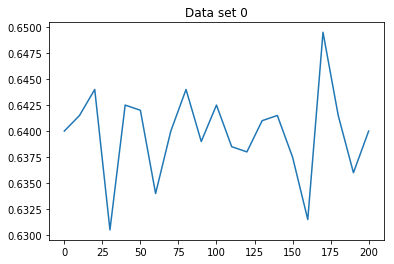

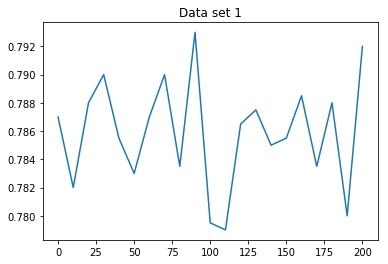

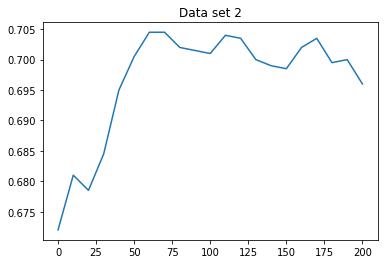

In [485]:
for i in range(3):
    plt.plot(Ts, temp_results[:, i, 0])
    plt.title('Data set {}'.format(i))
    plt.show()

In [487]:
temp_results_2 = []
Ts_2 = np.linspace(0, 200, 6)
for T in Ts_2:
    print("T", T)
    t = time.time()
    temp_results_2.append(svm_kernels(weighted_kernel(kernels, Ts=(T, T, T)), sksvm.SVC, repeats=4, kernel='precomputed'))
    print("Duration {:.2f}s".format(time.time() - t))

T 0.0
dataset: Validation 63.92 ± 0.44	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 78.11 ± 0.25	 Train 100.00 ± 0.00	 C=1e+01
dataset: Validation 67.21 ± 0.28	 Train 99.21 ± 0.01	 C=1e+00
total:   Validation 69.75 ± 0.33	 Train 99.74 ± 0.00	
Duration 69.12s
T 40.0
dataset: Validation 64.51 ± 0.36	 Train 95.76 ± 0.01	 C=1e+00
dataset: Validation 78.74 ± 0.18	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 69.15 ± 0.21	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 70.80 ± 0.25	 Train 98.59 ± 0.00	
Duration 72.07s
T 80.0
dataset: Validation 64.19 ± 0.26	 Train 94.43 ± 0.03	 C=1e+00
dataset: Validation 78.83 ± 0.34	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 70.21 ± 0.39	 Train 100.00 ± 0.00	 C=1e+01
total:   Validation 71.08 ± 0.33	 Train 98.14 ± 0.01	
Duration 68.71s
T 120.0
dataset: Validation 63.92 ± 0.11	 Train 94.25 ± 0.05	 C=1e+00
dataset: Validation 79.00 ± 0.29	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 70.25 ± 0.08	 Train 100.00 ± 0.00	 C=1e+03
total:   V

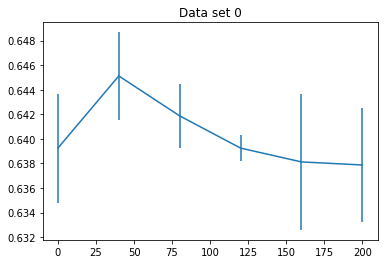

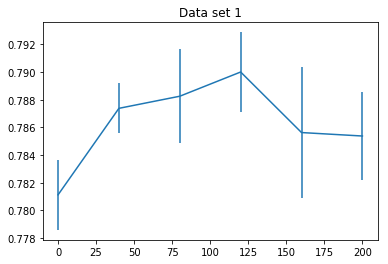

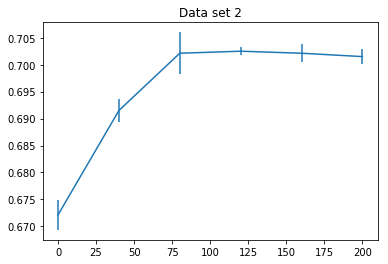

In [490]:
temp_results_2 = np.array(temp_results_2)
for i in range(3):
    plt.errorbar(Ts_2, temp_results_2[:, i, 0], yerr=temp_results_2[:, i, 1])
    plt.title('Data set {}'.format(i))
    plt.show()

In [496]:
best_Ts_2 = Ts_2[np.argmax(temp_results_2[:, :, 0], axis=0)]
safe_Ts_2 = Ts_2[np.argmax(temp_results_2[:, :, 0] - 2*temp_results_2[:, :, 1], axis=0)]

In [497]:
print(best_Ts_2)
print(safe_Ts_2)

[ 40. 120. 120.]
[ 40. 120. 120.]


## Final parameters

In [499]:
Ts = (40, 120, 120)
_ = svm_kernels(weighted_kernel(kernels, Ts=Ts), sksvm.SVC, repeats=4,
                kernel='precomputed',
                prediction_file='weighted_kernels_{}_{}_{}_sklearn'.format(*Ts))

dataset: Validation 64.26 ± 0.19	 Train 95.74 ± 0.04	 C=1e+00
dataset: Validation 78.49 ± 0.28	 Train 100.00 ± 0.00	 C=1e+02
dataset: Validation 70.24 ± 0.16	 Train 99.65 ± 0.00	 C=1e+00
total:   Validation 71.00 ± 0.21	 Train 98.46 ± 0.01	


In [501]:
Ts = (40, 120, 120)
_ = svm_kernels(weighted_kernel(kernels, Ts=Ts), svm.SVCCoordinate, repeats=4,
                kernel='precomputed', loss='hinge', intercept=1,
                prediction_file='weighted_kernels_{}_{}_{}'.format(*Ts))

dataset: Validation 64.18 ± 0.48	 Train 95.77 ± 0.01	 C=1e+00
dataset: Validation 78.71 ± 0.12	 Train 100.00 ± 0.00	 C=1e+03
dataset: Validation 69.86 ± 0.15	 Train 99.65 ± 0.00	 C=1e+00
total:   Validation 70.92 ± 0.25	 Train 98.47 ± 0.00	
